In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from analysis.utils import module_reload
module_reload('analysis')
from analysis.import_data import import_true_reco
from analysis.plot_matplotlib import plot_hist, export_figures

from tqdm.auto import tqdm
import json

repo_dir = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP'

/nfs/dust/ilc/user/bliewert/miniconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
df = import_true_reco(file_name='compare_truejet_matchingreco.root')
zhh = df[df['is_zhh'] == 1]
zzh = df[df['is_zzh'] == 1]

data = {
    'zhh': zhh,
    'zzh': zzh
}

Using cached file from /nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/cache/compare_truejet_matchingreco.root_zhh_zzh.npy


Muon

Angles

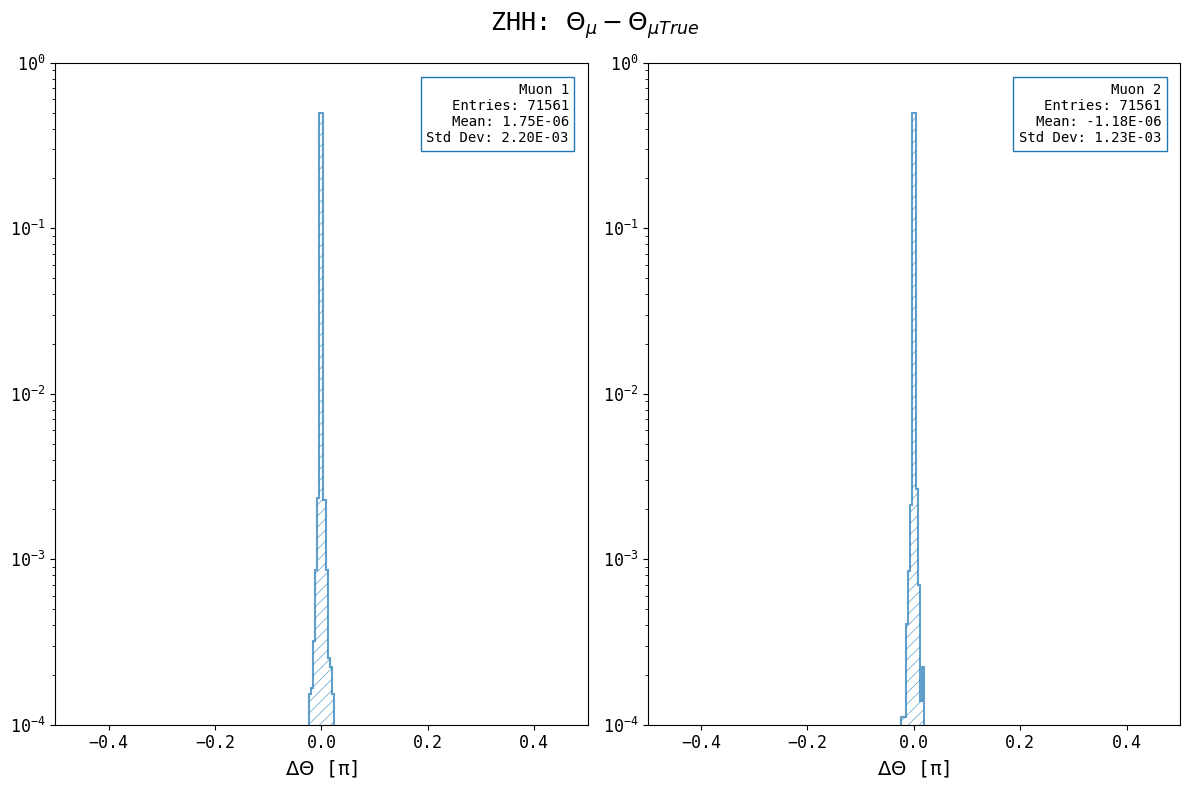

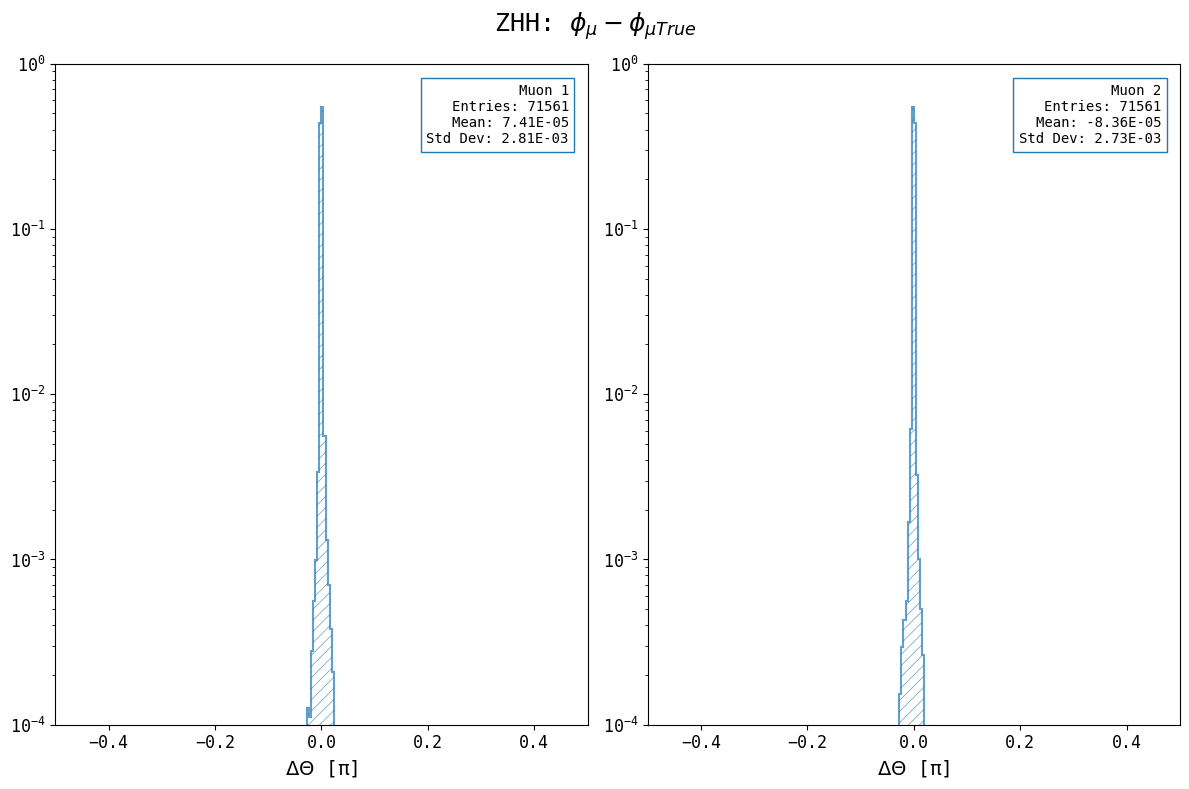

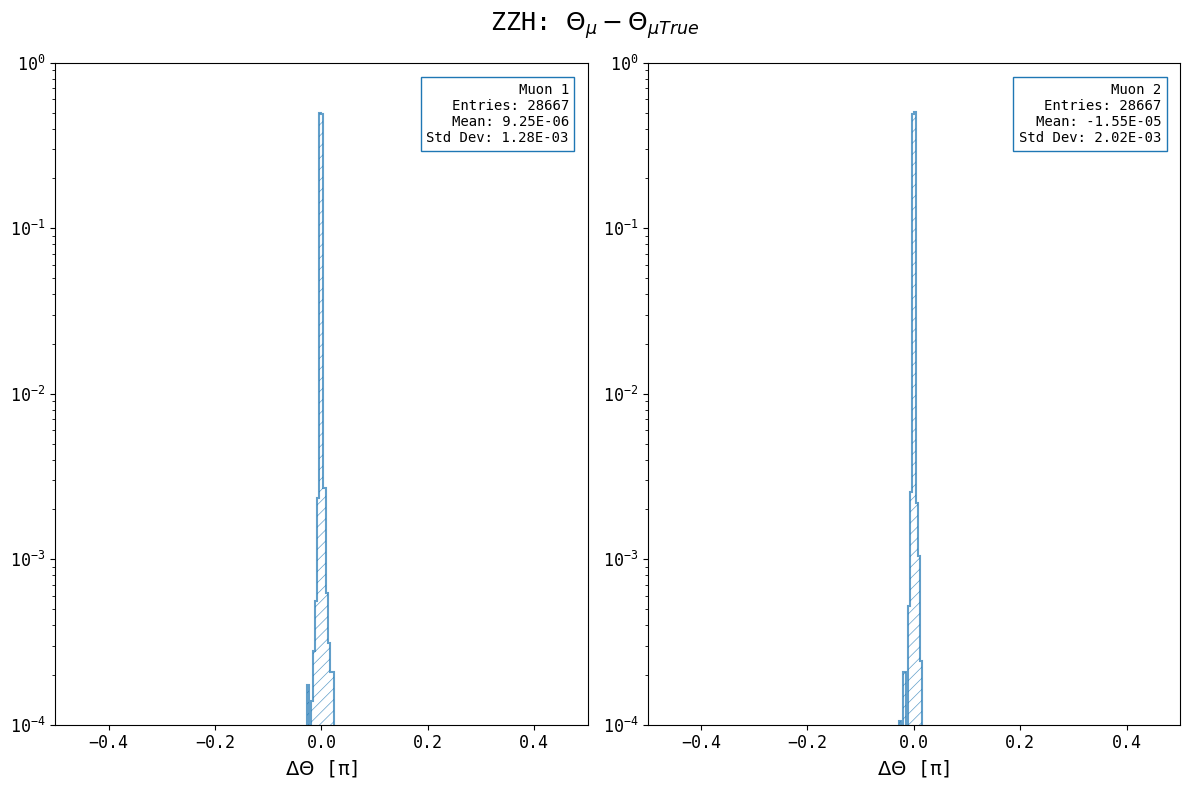

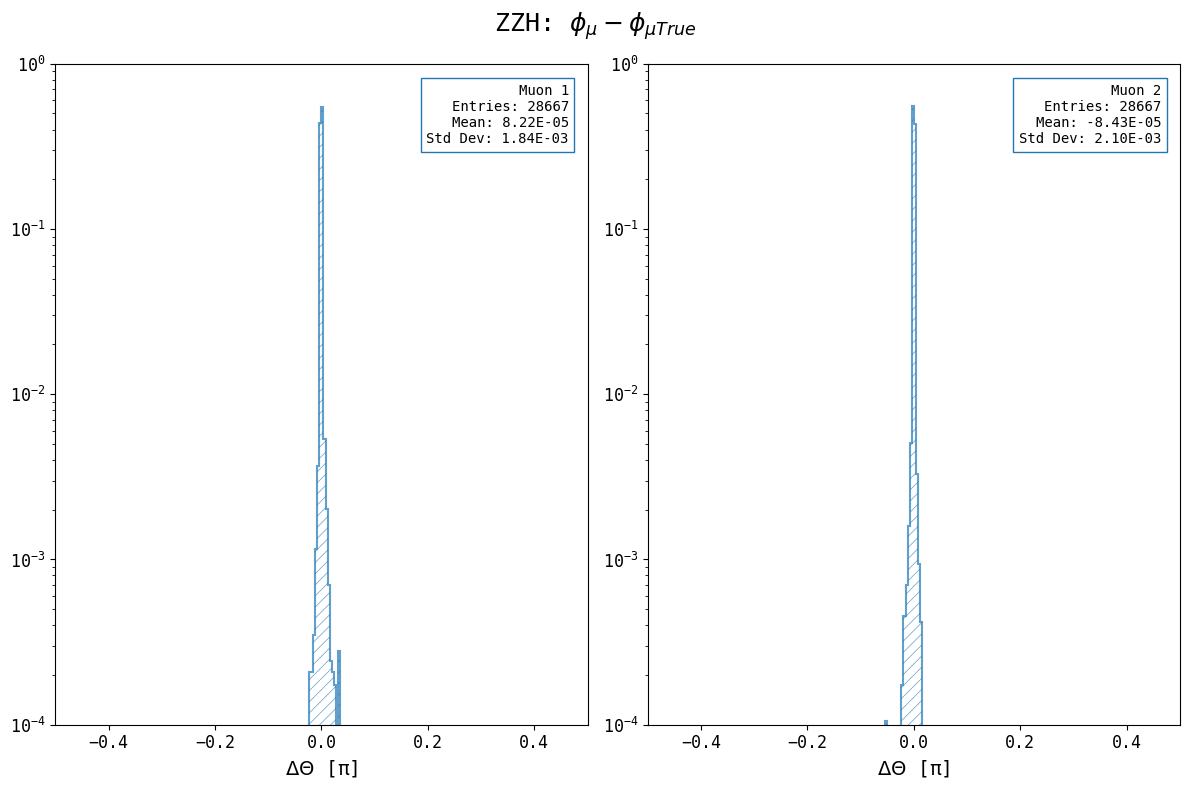

In [13]:
module_reload('analysis')
from typing import Optional
from analysis.plot_matplotlib import plot_hist
from analysis.transfer import plot_transfer
from analysis.fit_funcs import fit_funcs
from math import sqrt, pi

fit = None #"dbgauss_old"
figures = []
fitparams = []

for key in data:
    df = data[key]
    
    theta = { 'lep': [], 'true_lep': [] }
    phi   = { 'lep': [], 'true_lep': [] }
        
    for i in range(1, 3):
        for ptype in ['lep', 'true_lep']:
            theta[ptype].append(np.arccos(df[f"{ptype}{i}_pz"] / np.sqrt(df[f"{ptype}{i}_px"]**2 + df[f"{ptype}{i}_py"]**2 + df[f"{ptype}{i}_pz"]**2)))
            phi[ptype].append(np.arctan2(df[f"{ptype}{i}_py"], df[f"{ptype}{i}_px"]))
    
    #for ptype in ['lep', 'true_lep']:
    #    theta[ptype] = np.array(theta[ptype]).flatten()
    #    phi[ptype]   = np.array(phi[ptype]).flatten()
    
    j = 0
    for angle in (theta, phi):
        true = angle['true_lep']
        reco = angle['lep']
        quantity = r'\Theta' if j == 0 else r'\phi'
        
        figure, popts = plot_transfer([(reco[i], true[i]) for i in range(len(true))], f"{key.upper()}", fit=fit, quantity=quantity, xlabel=r"$\Delta\Theta$ [π]",
                                    true_label=r"\mu True", reco_label=r"\mu", xlim=(-.5,.5), ylim=(0.0001, 1.), n_bins=256, yscale="log", titles=['Muon 1', 'Muon 2'],
                                    plot_args={ 'scientific_stats': True, 'xlim_binning': (-.5,.5) })
        j += 1
        
        for fig in figure: figures.append(fig)
        for popt in popts: fitparams.append(popt.tolist() if popt is not None else None)
        
export_figures(f'{repo_dir}/notebooks/results/1_muons_angles_sep.pdf', figures)
with open(f'{repo_dir}/notebooks/results/1_muons_angles_sep_fitparams.txt', 'w', encoding='utf-8') as file:
    json.dump(fitparams, file, ensure_ascii=False, indent=4)

[0.04639371 0.1564788 ]
[-0.55364152  0.79887319]


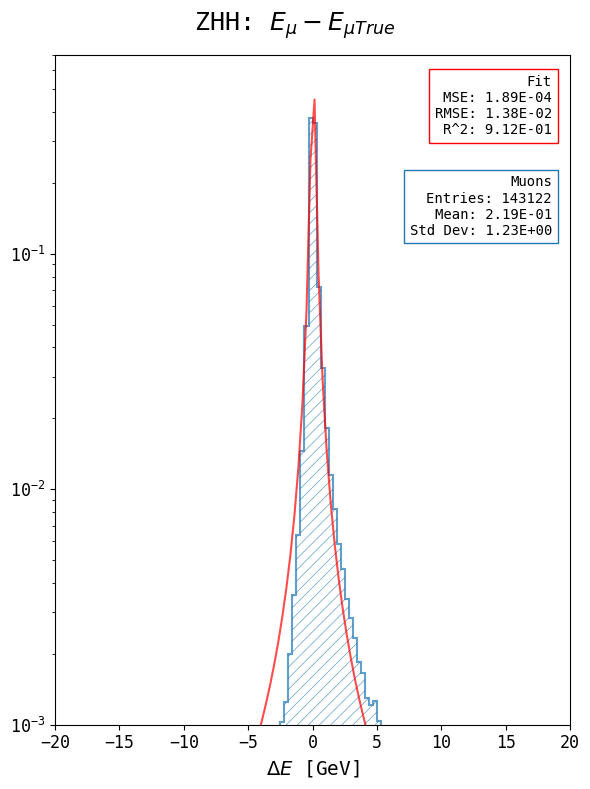

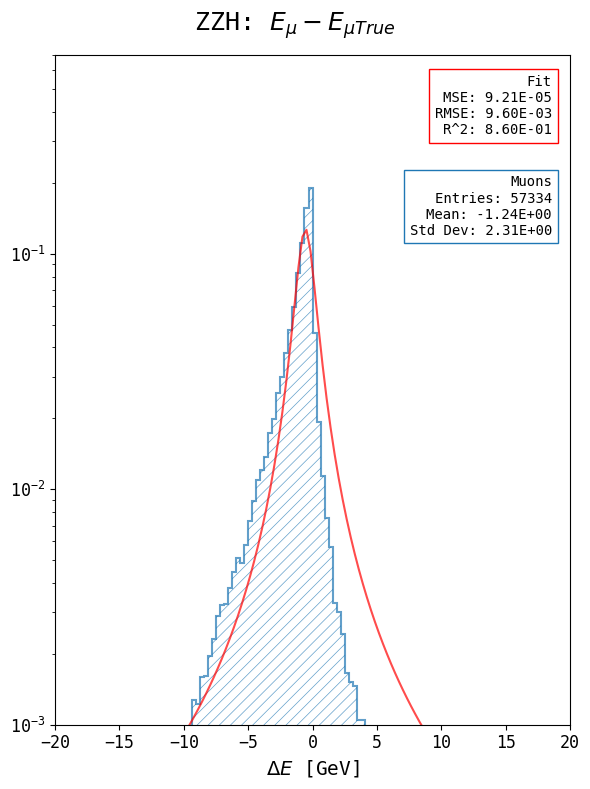

In [14]:
fit = "lorentz"
figures = []
fitparams = []

for key in data:
    df = data[key]
    transfer_data_reco = []
    transfer_data_true = []
    
    for i in range(1, 3):
        transfer_data_reco.append(df[f"lep{i}_e"])
        transfer_data_true.append(df[f"true_lep{i}_e"])
    
    transfer_data_reco = np.array(transfer_data_reco).flatten()
    transfer_data_true = np.array(transfer_data_true).flatten()
    
    figure, popts = plot_transfer([(transfer_data_reco, transfer_data_true)], f"{key.upper()}", fit=fit, xlim=(-20, 20),
                  true_label=r"\mu True", reco_label=r"\mu", ylim=(0.001, 0.7), yscale='log',
                  plot_args={ 'scientific_stats': True, 'x': 'Muons', 'xlim_binning': (-20,20) });
    
    for fig in figure: figures.append(fig)
    for popt in popts: fitparams.append(popt.tolist() if popt is not None else None)
    
export_figures(f'{repo_dir}/notebooks/results/1_muon_energy.pdf', figures)
with open(f'{repo_dir}/notebooks/results/1_muon_energy_fitparams.txt', 'w', encoding='utf-8') as file:
    json.dump(fitparams, file, ensure_ascii=False, indent=4)

[0.04667263 0.15609314]
[0.10975263 0.21073754]
[-0.75713539  0.633663  ]
[-0.75034473  0.5646829 ]


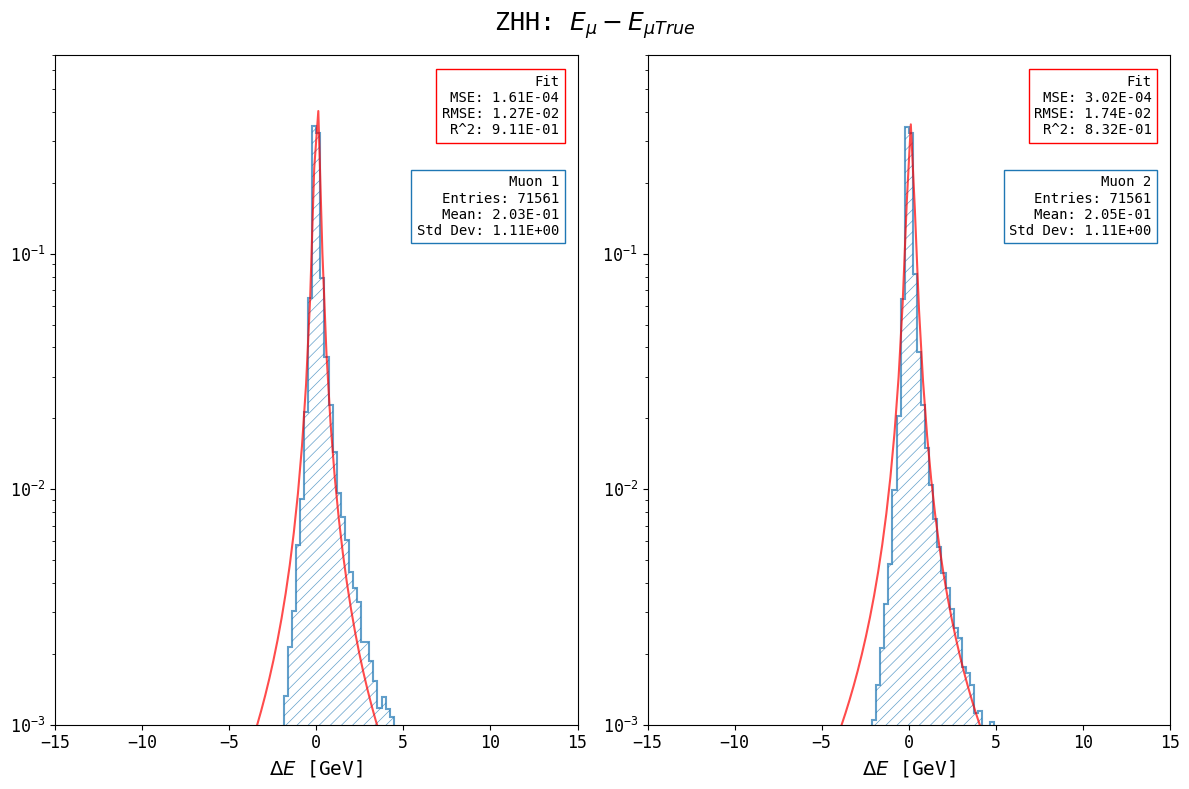

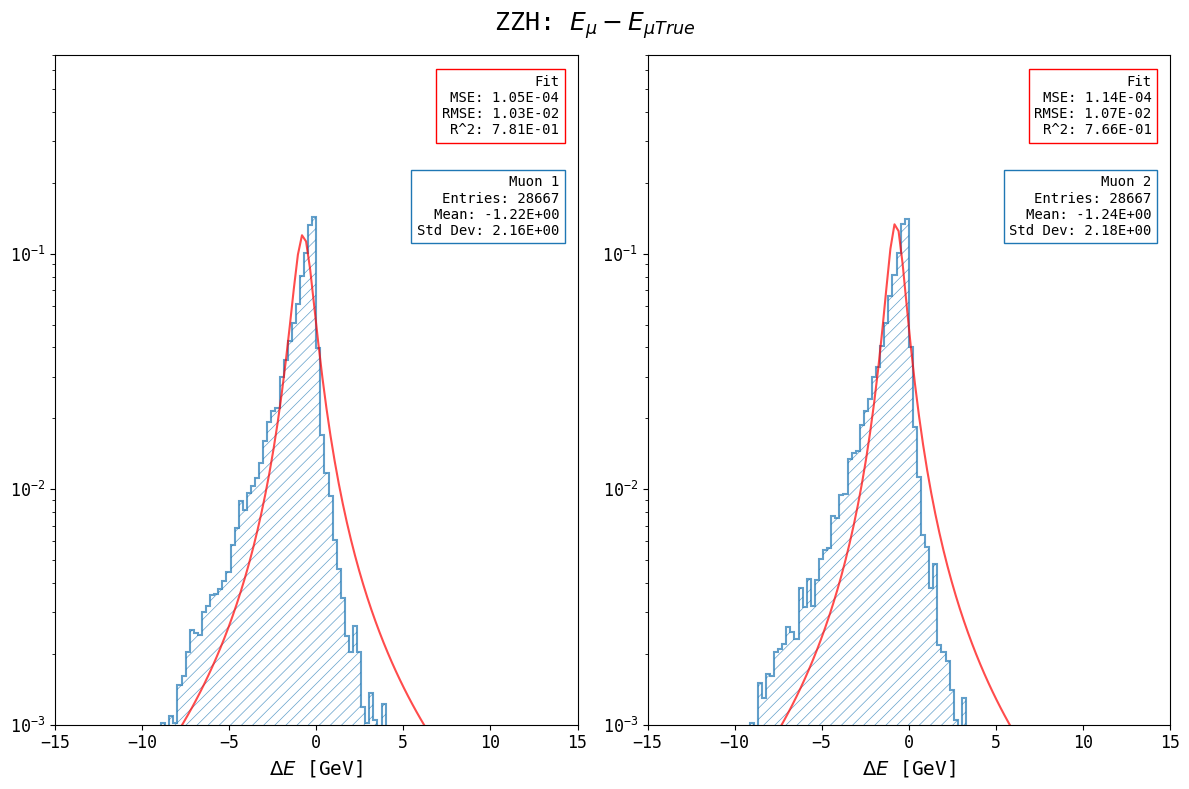

In [15]:
module_reload('analysis')
from analysis.import_data import import_true_reco
from analysis.plot_matplotlib import plot_hist, export_figures
from analysis.transfer import plot_transfer

fit = "lorentz"
figures = []

for key in data:
    transfer_data = []
    df = data[key]
    
    for i in range(1, 3):
        transfer_data.append((df[f"lep{i}_e"], df[f"true_lep{i}_e"]))

    fig, popt = plot_transfer(transfer_data, f"{key.upper()}", fit=fit, true_label=r"\mu True", reco_label=r"\mu", titles=['Muon 1', 'Muon 2'],
                              ylim=(0.001, 0.7), xlim=(-15,15), yscale="log",
                              plot_args={ 'scientific_stats': True, 'xlim_binning': (-15,15) });
    
    for fig in figure: figures.append(fig)
    for popt in popts: fitparams.append(popt.tolist() if popt is not None else None)
    
export_figures(f'{repo_dir}/notebooks/results/1_muon_energy_sep.pdf', figures)
with open(f'{repo_dir}/notebooks/results/1_muon_energy_sep_fitparams.txt', 'w', encoding='utf-8') as file:
    json.dump(fitparams, file, ensure_ascii=False, indent=4)